# Architecture of a classification neural network

| Hyperparameter                  | Binary Classification                             | Multiclass Classification                      |
|---------------------------------|----------------------------------------------------|------------------------------------------------|
| Input layer shape (in_features) | Same as number of features (e.g. 5 for age, sex, height, weight, smoking status in heart disease prediction) | Same as binary classification                   |
| Hidden layer(s)                 | Problem specific, minimum = 1, maximum = unlimited | Same as binary classification                   |
| Neurons per hidden layer        | Problem specific, generally 10 to 512             | Same as binary classification                   |
| Output layer shape (out_features) | 1 (one class or the other)                      | 1 per class (e.g. 3 for food, person or dog photo) |
| Hidden layer activation         | Usually ReLU (rectified linear unit) but can be many others | Same as binary classification           |
| Output activation               | Sigmoid (torch.sigmoid in PyTorch)                 | Softmax (torch.softmax in PyTorch)              |
| Loss function                    | Binary crossentropy (torch.nn.BCELoss in PyTorch) | Cross entropy (torch.nn.CrossEntropyLoss in PyTorch) |
| Optimizer                        | SGD (stochastic gradient descent), Adam (see torch.optim for more options) | Same as binary classification                   |

## 1. Create dataset

In [137]:
from sklearn.datasets import make_circles

n_samples = 1000
X_sample, y_sample = make_circles(n_samples=n_samples, noise=0.03, random_state=42)

In [138]:
X_sample.shape, y_sample.shape

((1000, 2), (1000,))

In [139]:
X_sample[:5], y_sample[:5]

(array([[ 0.75424625,  0.23148074],
        [-0.75615888,  0.15325888],
        [-0.81539193,  0.17328203],
        [-0.39373073,  0.69288277],
        [ 0.44220765, -0.89672343]]),
 array([1, 1, 1, 1, 0]))

In [140]:
import pandas as pd

circles = pd.DataFrame({"X1": X_sample[:, 0], "X2": X_sample[:, 1], "label": y_sample})
circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


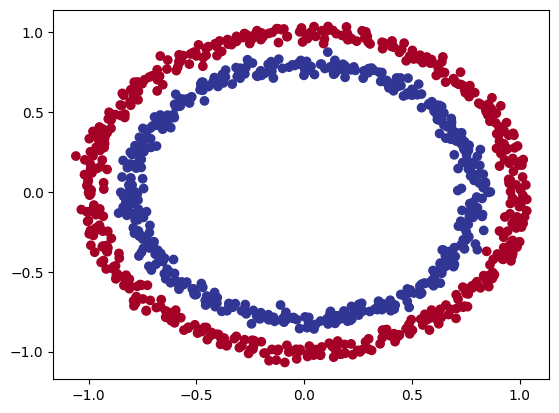

In [141]:
import matplotlib.pyplot as plt

plt.scatter(x=X_sample[:, 0], y=X_sample[:, 1], c=y_sample, cmap='RdYlBu')

## 2. Device agnostic

In [142]:
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## 3. Data to Tensor

In [143]:
X = torch.from_numpy(X_sample).type(torch.float32).to(device)
y = torch.from_numpy(y_sample).type(torch.float32).to(device)

X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]], device='cuda:0'),
 tensor([1., 1., 1., 1., 0.], device='cuda:0'))

In [144]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [145]:
y_train.shape, y_test.shape

(torch.Size([800]), torch.Size([200]))

## 4. Build model

In [146]:
import torch.nn as nn

class Classification(nn.Module):
    def __init__(self):
        super(Classification, self).__init__()
        self.linear1 = nn.Linear(in_features=2, out_features=5)
        self.linear2 = nn.Linear(in_features=5, out_features=1)
    
    def forward(self, x):
        out = self.linear1(x)
        out = self.linear2(out)
        return out

In [147]:
torch.manual_seed(42)

model = Classification()

model.to(device)

Classification(
  (linear1): Linear(in_features=2, out_features=5, bias=True)
  (linear2): Linear(in_features=5, out_features=1, bias=True)
)

In [148]:
model.state_dict()

OrderedDict([('linear1.weight',
              tensor([[ 0.5406,  0.5869],
                      [-0.1657,  0.6496],
                      [-0.1549,  0.1427],
                      [-0.3443,  0.4153],
                      [ 0.6233, -0.5188]], device='cuda:0')),
             ('linear1.bias',
              tensor([0.6146, 0.1323, 0.5224, 0.0958, 0.3410], device='cuda:0')),
             ('linear2.weight',
              tensor([[-0.0631,  0.3448,  0.0661, -0.2088,  0.1140]], device='cuda:0')),
             ('linear2.bias', tensor([-0.2060], device='cuda:0'))])

### Alternative way to build a model

**`nn.Sequential`**():
- A sequential container. Modules will be added to it in the order they are passed in the constructor.
- The value a Sequential provides over manually calling a sequence of modules is that it allows treating the whole container as a single module

In [149]:
torch.manual_seed(42)

model = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)
model

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [150]:
model.state_dict()

OrderedDict([('0.weight',
              tensor([[ 0.5406,  0.5869],
                      [-0.1657,  0.6496],
                      [-0.1549,  0.1427],
                      [-0.3443,  0.4153],
                      [ 0.6233, -0.5188]], device='cuda:0')),
             ('0.bias',
              tensor([0.6146, 0.1323, 0.5224, 0.0958, 0.3410], device='cuda:0')),
             ('1.weight',
              tensor([[-0.0631,  0.3448,  0.0661, -0.2088,  0.1140]], device='cuda:0')),
             ('1.bias', tensor([-0.2060], device='cuda:0'))])

In [151]:
with torch.inference_mode():
    y_pred = model(X_test)

y_pred[:5], y_test[:5]

(tensor([[-0.1269],
         [-0.0967],
         [-0.1908],
         [-0.1089],
         [-0.1667]], device='cuda:0'),
 tensor([1., 0., 1., 0., 1.], device='cuda:0'))

### Loss function and Optimizer

| Loss function/Optimizer      | Problem type                 | PyTorch Code                                |
|------------------------------|------------------------------|---------------------------------------------|
| Stochastic Gradient Descent (SGD) optimizer | Classification, regression, many others. | torch.optim.SGD()                     |
| Adam Optimizer               | Classification, regression, many others. | torch.optim.Adam()                    |
| Binary cross entropy loss    | Binary classification         | torch.nn.BCELossWithLogits or torch.nn.BCELoss |
| Cross entropy loss           | Mutli-class classification    | torch.nn.CrossEntropyLoss                    |
| Mean absolute error (MAE) or L1 Loss | Regression             | torch.nn.L1Loss                        |
| Mean squared error (MSE) or L2 Loss | Regression             | torch.nn.MSELoss                       |

In [152]:
criterion = nn.BCEWithLogitsLoss()

learning_rate = 0.1
optimizer = torch.optim.SGD(model.parameters(), learning_rate)

## 5. Train model

In [153]:
epochs = 100

for epoch in range(epochs):
    model.train()
    
    y_pred = model(X_train).squeeze()
    loss = criterion(y_pred, y_train)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch+1) % 10 == 0:
        model.eval()
        with torch.inference_mode():
            test_pred = model(X_test).squeeze()
            test_loss = criterion(test_pred, y_test)
        print(f"Epoch: {epoch+1}, Train loss: {loss:.5f}, Test loss: {test_loss:.5f}")

Epoch: 10, Train loss: 0.69413, Test loss: 0.69621
Epoch: 20, Train loss: 0.69346, Test loss: 0.69587
Epoch: 30, Train loss: 0.69322, Test loss: 0.69577
Epoch: 40, Train loss: 0.69313, Test loss: 0.69573
Epoch: 50, Train loss: 0.69308, Test loss: 0.69569
Epoch: 60, Train loss: 0.69306, Test loss: 0.69565
Epoch: 70, Train loss: 0.69305, Test loss: 0.69559
Epoch: 80, Train loss: 0.69304, Test loss: 0.69554
Epoch: 90, Train loss: 0.69303, Test loss: 0.69548
Epoch: 100, Train loss: 0.69302, Test loss: 0.69543


## 6. Evaluate model

In [154]:
import requests
import os

helper = 'helper_functions.py'

if os.path.isfile(helper):
    print(f"{helper} exists. Skipping download")
else:
    print(f"Start downloading {helper}")
    respond = requests.get('https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py')
    with open(helper, 'wb') as f:
        f.write(respond.content)


helper_functions.py exists. Skipping download


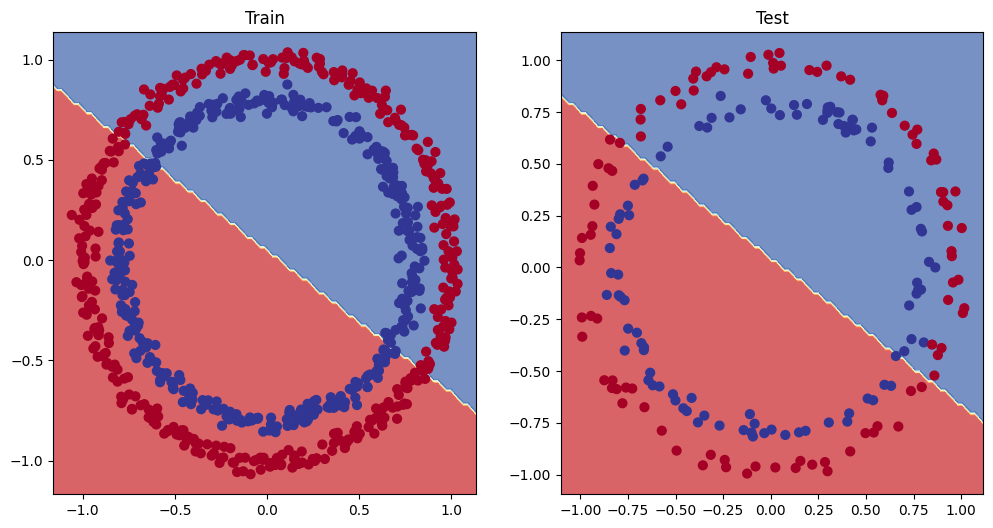

In [155]:
from helper_functions import plot_decision_boundary

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model, X_test, y_test)

## 7. Improve model

- Add more hidden layers
- Add more hidden units
- More epochs
- Change the activate function
- Change the learning rate
- Change the loss function
- Change the optimization function

In [156]:
class ClassificationV2(nn.Module):
    def __init__(self):
        super(ClassificationV2, self).__init__()
        self.linear1 = nn.Linear(in_features=2, out_features=10)
        self.linear2 = nn.Linear(in_features=10, out_features=10)
        self.linear3 = nn.Linear(in_features=10, out_features=1)
    
    def forward(self, x):
        out = self.linear1(x)
        out = self.linear2(out)
        out = self.linear3(out)
        return out

In [157]:
model = ClassificationV2().to(device)
model

ClassificationV2(
  (linear1): Linear(in_features=2, out_features=10, bias=True)
  (linear2): Linear(in_features=10, out_features=10, bias=True)
  (linear3): Linear(in_features=10, out_features=1, bias=True)
)

In [158]:
criterion = nn.BCEWithLogitsLoss()

learning_rate = 0.1 
optimizer = torch.optim.SGD(model.parameters(), learning_rate)

In [159]:
import helper_functions

helper_functions.set_seeds()

epochs = 1000

for epoch in range(epochs):
    model.train()
    
    y_pred = model(X_train).squeeze()
    loss = criterion(y_pred, y_train)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch+1) % 100 == 0:
        model.eval()
        with torch.inference_mode():
            test_pred = model(X_test).squeeze()
            test_loss = criterion(test_pred, y_test)
        print(f"Epoch: {epoch+1}, Train loss: {loss:.5f}, Test loss: {test_loss:.5f}")

Epoch: 100, Train loss: 0.69308, Test loss: 0.69443
Epoch: 200, Train loss: 0.69299, Test loss: 0.69439
Epoch: 300, Train loss: 0.69298, Test loss: 0.69445
Epoch: 400, Train loss: 0.69298, Test loss: 0.69451
Epoch: 500, Train loss: 0.69298, Test loss: 0.69455
Epoch: 600, Train loss: 0.69298, Test loss: 0.69458
Epoch: 700, Train loss: 0.69298, Test loss: 0.69460
Epoch: 800, Train loss: 0.69298, Test loss: 0.69462
Epoch: 900, Train loss: 0.69298, Test loss: 0.69464
Epoch: 1000, Train loss: 0.69298, Test loss: 0.69465


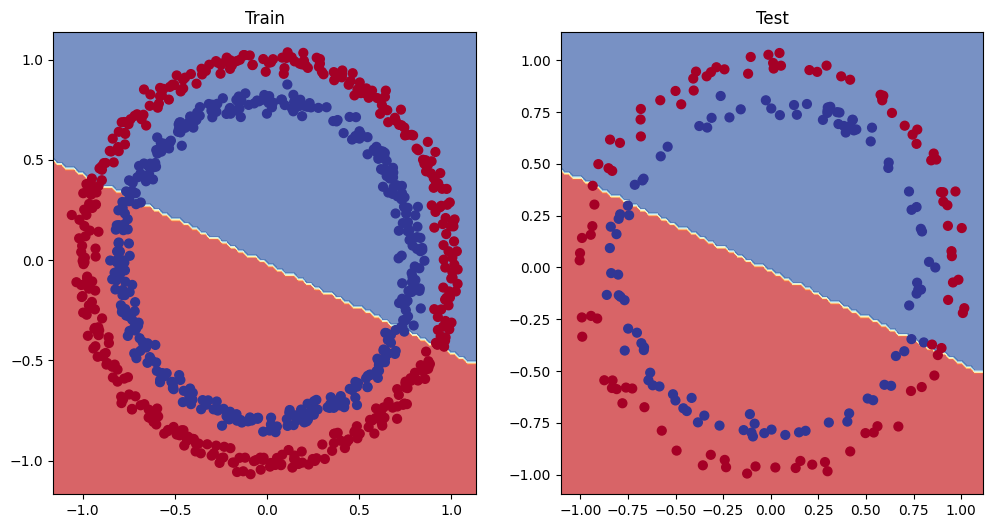

In [160]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model, X_test, y_test)

### Testing on smaller data

In [161]:
weight = 0.7
bias = 0.3
start = 0
end = 1
step = 0.01

In [162]:
X2 = torch.arange(start, end, step, device=device).unsqueeze(1)
y2 = weight * X2 + bias

In [163]:
X2.shape, y2.shape

(torch.Size([100, 1]), torch.Size([100, 1]))

In [164]:
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, shuffle=False)

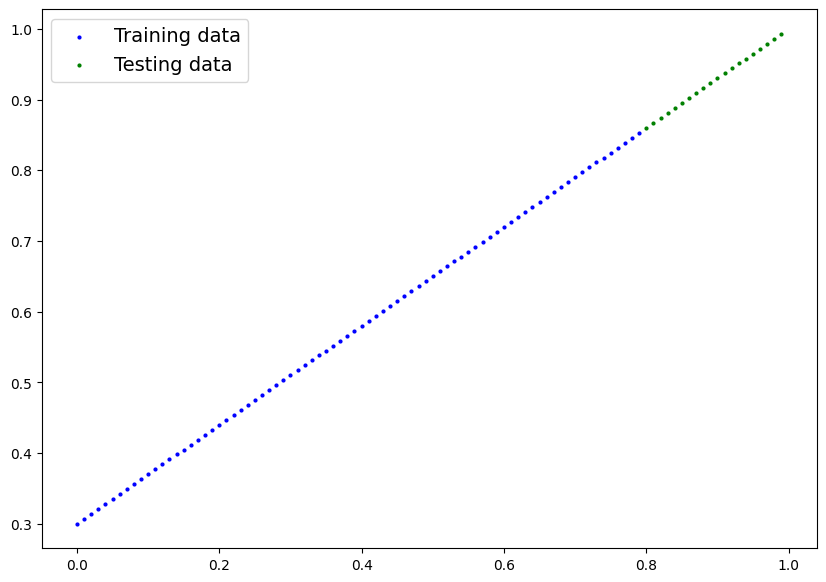

In [165]:
X2_train_cpu, y2_train_cpu, X2_test_cpu, y2_test_cpu = (x.cpu() for x in [X2_train, y2_train, X2_test, y2_test])
helper_functions.plot_predictions(X2_train_cpu, y2_train_cpu, X2_test_cpu, y2_test_cpu)

### Adjust the model to fit new data

In [166]:
model2 = nn.Sequential(
    nn.Linear(1, 10),
    nn.Linear(10, 10),
    nn.Linear(10, 1)
).to(device)

model2

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [167]:
criterion = nn.L1Loss()
optimizer = torch.optim.SGD(model2.parameters(), lr=0.01)

In [168]:
helper_functions.set_seeds()

epochs = 1000

for epoch in range(epochs):
    model2.train()

    y2_pred = model2(X2_train)
    loss = criterion(y2_pred, y2_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch+1) % 100 == 0:
        model.eval()
        with torch.inference_mode():
            test2_pred = model2(X2_test)
            test_loss = criterion(test2_pred, y2_test)
        print(f"Epoch: {epoch+1}, Train loss: {loss:.5f}, Test loss: {test_loss:.5f}")

Epoch: 100, Train loss: 0.00844, Test loss: 0.04399
Epoch: 200, Train loss: 0.01067, Test loss: 0.04499
Epoch: 300, Train loss: 0.01366, Test loss: 0.04484
Epoch: 400, Train loss: 0.01456, Test loss: 0.04422
Epoch: 500, Train loss: 0.01406, Test loss: 0.04379
Epoch: 600, Train loss: 0.01373, Test loss: 0.04288
Epoch: 700, Train loss: 0.01332, Test loss: 0.04211
Epoch: 800, Train loss: 0.01309, Test loss: 0.04086
Epoch: 900, Train loss: 0.01289, Test loss: 0.04045
Epoch: 1000, Train loss: 0.01250, Test loss: 0.03951


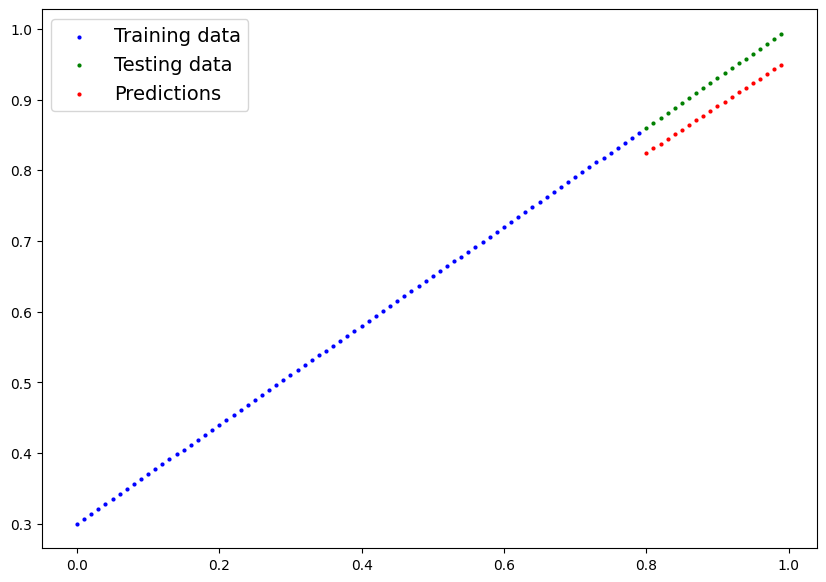

In [169]:
model.eval()
with torch.inference_mode():
    test2_pred = model2(X2_test)
helper_functions.plot_predictions(X2_train_cpu, y2_train_cpu, X2_test_cpu, y2_test_cpu, predictions=test2_pred.cpu())

## 8. Build a non-linear model

In [178]:
from sklearn.model_selection import train_test_split

X = torch.from_numpy(X_sample).type(torch.float32).to(device)
y = torch.from_numpy(y_sample).type(torch.float32).to(device)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [179]:
class ClassificationV3(nn.Module):
    def __init__(self):
        super(ClassificationV3, self).__init__()
        self.layer_in = nn.Linear(2, 10)
        self.layer_hidden = nn.Linear(10, 10)
        self.layer_out = nn.Linear(10, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out = self.layer_in(x)
        out = self.relu(out)

        out = self.layer_hidden(out)
        out = self.relu(out)

        out = self.layer_out(out)
        out = self.sigmoid(out)
        return out

In [180]:
model3 = ClassificationV3().to(device)
model3

ClassificationV3(
  (layer_in): Linear(in_features=2, out_features=10, bias=True)
  (layer_hidden): Linear(in_features=10, out_features=10, bias=True)
  (layer_out): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
)

In [181]:
criterion = nn.BCELoss()

learning_rate = 0.1
optimizer = torch.optim.SGD(model3.parameters(), learning_rate)

In [182]:
helper_functions.set_seeds()

epochs = 10000

for epoch in range(epochs):
    model3.train()

    y_pred = model3(X_train).squeeze()
    loss = criterion(y_pred, y_train)

    train_acc = helper_functions.accuracy_fn(y_train, torch.round(y_pred).squeeze())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch+1) % 1000 == 0:
        model.eval()
        with torch.inference_mode():
            test_pred = model3(X_test).squeeze()
            test_loss = criterion(test_pred, y_test)
            test_acc = helper_functions.accuracy_fn(y_test, torch.round(test_pred).squeeze())
        print(f"Epoch: {epoch+1}, Train loss: {loss:.5f}, Train acc: {train_acc:.2f}%, Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")


Epoch: 1000, Train loss: 0.56890, Train acc: 87.62%, Test loss: 0.57440, Test acc: 86.50%
Epoch: 2000, Train loss: 0.04182, Train acc: 99.88%, Test loss: 0.06591, Test acc: 100.00%
Epoch: 3000, Train loss: 0.01673, Train acc: 99.88%, Test loss: 0.03364, Test acc: 100.00%
Epoch: 4000, Train loss: 0.01049, Train acc: 100.00%, Test loss: 0.02451, Test acc: 99.50%
Epoch: 5000, Train loss: 0.00765, Train acc: 100.00%, Test loss: 0.01993, Test acc: 99.50%
Epoch: 6000, Train loss: 0.00603, Train acc: 100.00%, Test loss: 0.01726, Test acc: 99.50%
Epoch: 7000, Train loss: 0.00500, Train acc: 100.00%, Test loss: 0.01557, Test acc: 99.50%
Epoch: 8000, Train loss: 0.00428, Train acc: 100.00%, Test loss: 0.01451, Test acc: 99.50%
Epoch: 9000, Train loss: 0.00375, Train acc: 100.00%, Test loss: 0.01374, Test acc: 99.50%
Epoch: 10000, Train loss: 0.00333, Train acc: 100.00%, Test loss: 0.01317, Test acc: 99.50%
